# 2. VAE
- ## VAE를 이용하여 꽃 이미지를 생성하기
- ## Kaggle의 Flowers imitation Dataset을 사용

### 1. 데이터 불러오기 및 시각화

### 참고링크
- https://goldenrabbit.co.kr/2023/07/31/%ED%8C%8C%EC%9D%B4%ED%86%A0%EC%B9%98-%EB%94%A5%EB%9F%AC%EB%8B%9D-gan%EC%9C%BC%EB%A1%9C-%EC%82%AC%EB%9E%8C-%EC%96%BC%EA%B5%B4-%EB%A7%8C%EB%93%A4%EA%B8%B0/
- https://www.kaggle.com/code/dantatartes/anime-vae
- https://velog.io/@hong_journey/VAEVariational-AutoEncoder-%EA%B5%AC%ED%98%84%ED%95%98%EA%B8%B0
- https://github.com/Jackson-Kang/Pytorch-VAE-tutorial/blob/master/01_Variational_AutoEncoder.ipynb
- https://ljm565.github.io/contents/VAE2.html


In [1]:
# 구글 드라이브 마운트

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 데이터셋 불러오기
!cp "/content/drive/MyDrive/flower.zip" "."
!unzip "./flower.zip" -d "./GAN/"

Archive:  ./flower.zip
  inflating: ./GAN/flowers_imitation/0.png  
  inflating: ./GAN/flowers_imitation/1.png  
  inflating: ./GAN/flowers_imitation/10.png  
  inflating: ./GAN/flowers_imitation/100.png  
  inflating: ./GAN/flowers_imitation/1000.png  
  inflating: ./GAN/flowers_imitation/1001.png  
  inflating: ./GAN/flowers_imitation/1002.png  
  inflating: ./GAN/flowers_imitation/1003.png  
  inflating: ./GAN/flowers_imitation/1004.png  
  inflating: ./GAN/flowers_imitation/1005.png  
  inflating: ./GAN/flowers_imitation/1006.png  
  inflating: ./GAN/flowers_imitation/1007.png  
  inflating: ./GAN/flowers_imitation/1008.png  
  inflating: ./GAN/flowers_imitation/1009.png  
  inflating: ./GAN/flowers_imitation/101.png  
  inflating: ./GAN/flowers_imitation/1010.png  
  inflating: ./GAN/flowers_imitation/1011.png  
  inflating: ./GAN/flowers_imitation/1012.png  
  inflating: ./GAN/flowers_imitation/1013.png  
  inflating: ./GAN/flowers_imitation/1014.png  
  inflating: ./GAN/flowers_

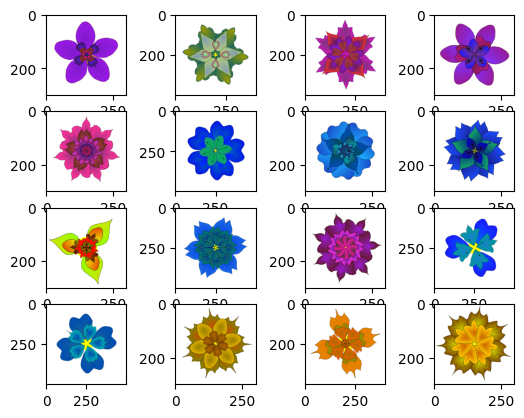

In [3]:
import glob
import matplotlib.pyplot as plt
import os
from PIL import Image

path = "/content/GAN/flowers_imitation"
imgs = glob.glob(os.path.join(path, "*"))

# 이미지 16개 시각화
for i in range(16):
  plt.subplot(4, 4, i + 1)
  img = Image.open(imgs[i])
  plt.imshow(img)
plt.show()

### 2. 하이퍼파라미터 설정 및 데이터 전처리



In [4]:
import torch

batch_size = 32
img_size = 64
epoch = 200
torch.cuda.set_device("cuda:0")

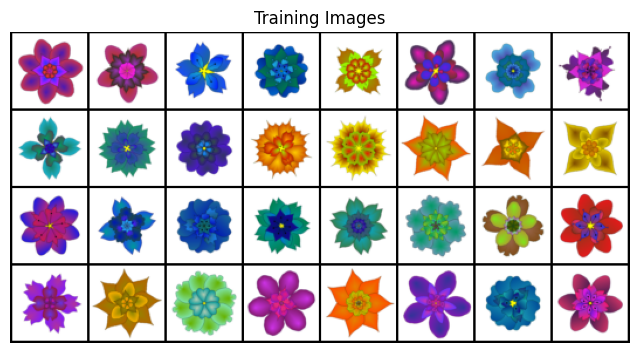

In [5]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torchvision.utils as vutils
import numpy as np

# 이미지 전처리
tf = transforms.Compose([
    transforms.Resize(img_size),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
])

dataset = ImageFolder(
    root = "/content/GAN",
    transform = tf
)

dataloader = torch.utils.data.DataLoader(dataset, batch_size = batch_size,
                                         shuffle = True, num_workers = 2)

real_batch = next(iter(dataloader))
plt.figure(figsize = (8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0], padding = 2, normalize = True).cpu(), (1, 2, 0)))

### 3. Flatten

In [6]:
import torch.nn as nn

In [7]:
class Flatten(nn.Module):
  def forward(self, input):
    return input.view(input.size(0), -1)

class UnFlatten(nn.Module):
  def forward(self, input, size = 1024):
    return input.view(input.size(0), size, 1, 1)

### 4. VAE

In [8]:
class VAE(nn.Module):
  # hidden layer의 차원 = 1024, latent variable의 차원 = 32
  def __init__(self, img_channels = 3, h_dim = 1024, z_dim = 32):
    super(VAE, self).__init__()

    """Encoder"""
    self.encoder = nn.Sequential(
        nn.Conv2d(img_channels, 32, kernel_size = 4, stride = 2),
        nn.ReLU(),

        nn.Conv2d(32, 64, kernel_size = 4, stride = 2),
        nn.ReLU(),

        nn.Conv2d(64, 128, kernel_size = 4, stride = 2),
        nn.ReLU(),

        nn.Conv2d(128, 256, kernel_size = 4, stride = 2),
        nn.ReLU(),
        Flatten()
    )

    # z(i, l) mu(i) + sigma(i) * epsilon(l)
    self.mu = nn.Linear(h_dim, z_dim)
    self.sigma = nn.Linear(h_dim, z_dim)
    self.z2h = nn.Linear(z_dim, h_dim)

    """Decoder"""
    self.decoder = nn.Sequential(
        UnFlatten(),
        nn.ConvTranspose2d(h_dim, 128, kernel_size = 5, stride = 2),
        nn.ReLU(),

        nn.ConvTranspose2d(128, 64, kernel_size = 5, stride = 2),
        nn.ReLU(),

        nn.ConvTranspose2d(64, 32, kernel_size = 6, stride = 2),
        nn.ReLU(),

        nn.ConvTranspose2d(32, img_channels, kernel_size = 6, stride = 2),
        nn.Sigmoid()
    )
  # z(i, l) mu(i) + sigma(i) * epsilon(l)
  def reparameterize(self, mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + std * eps # z

  def bottleneck(self, h):
    mu = self.mu(h)
    logvar = self.sigma(h)
    z = self.reparameterize(mu, logvar)
    return z, mu, logvar

  def encode(self, x):
    return self.bottleneck(self.encoder(x))[0]

  def decode(self, z):
    return self.decoder(self.z2h(z))

  def forward(self, x):
    h = self.encoder(x)
    z, mu, logvar = self.bottleneck(h)
    z = self.z2h(z)
    return self.decoder(z), mu, logvar

### 5. Loss Function과 Optimizer 정의

In [9]:
from IPython.display import HTML, display, FileLink
from torch.optim import Adam
import tqdm

BCELoss = nn.BCELoss()

def loss_function(x_hat, x, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat.view(-1, img_size*img_size*3),
                                                           x.view(-1, img_size*img_size*3),
                                                           reduction='sum')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

model = VAE()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

### 6. 모델 학습

In [10]:
print("start training")

for epochs in range(epoch):
  trainLoss = 0
  for data, _ in tqdm.tqdm(dataloader):

    optimizer.zero_grad()
    reconBatch, mu, logvar = model(data)
    loss = loss_function(reconBatch, data, mu, logvar)
    loss.backward()
    trainLoss += loss.item()
    optimizer.step()

  torch.save(model.state_dict(), "vae.pth")
  print('[%d/%d][155/%d]\tLoss: %f'
            % (epochs + 1, epoch, len(dataloader), trainLoss / len(dataset)))
model.eval()
print('training finish')

start training


100%|██████████| 155/155 [01:04<00:00,  2.41it/s]


[1/200][155/155]	Loss: 4385.492326


100%|██████████| 155/155 [01:05<00:00,  2.37it/s]


[2/200][155/155]	Loss: 3847.932204


100%|██████████| 155/155 [01:11<00:00,  2.16it/s]


[3/200][155/155]	Loss: 3428.554735


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


[4/200][155/155]	Loss: 3100.837237


100%|██████████| 155/155 [01:04<00:00,  2.41it/s]


[5/200][155/155]	Loss: 2963.907378


100%|██████████| 155/155 [01:03<00:00,  2.44it/s]


[6/200][155/155]	Loss: 2890.066800


100%|██████████| 155/155 [01:04<00:00,  2.40it/s]


[7/200][155/155]	Loss: 2846.179073


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


[8/200][155/155]	Loss: 2808.067531


100%|██████████| 155/155 [01:02<00:00,  2.48it/s]


[9/200][155/155]	Loss: 2778.826756


100%|██████████| 155/155 [01:04<00:00,  2.40it/s]


[10/200][155/155]	Loss: 2761.383878


100%|██████████| 155/155 [01:02<00:00,  2.48it/s]


[11/200][155/155]	Loss: 2740.939365


100%|██████████| 155/155 [01:05<00:00,  2.38it/s]


[12/200][155/155]	Loss: 2726.565196


100%|██████████| 155/155 [01:03<00:00,  2.42it/s]


[13/200][155/155]	Loss: 2714.127975


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


[14/200][155/155]	Loss: 2701.173071


100%|██████████| 155/155 [01:00<00:00,  2.55it/s]


[15/200][155/155]	Loss: 2690.633904


100%|██████████| 155/155 [01:05<00:00,  2.35it/s]


[16/200][155/155]	Loss: 2682.508733


100%|██████████| 155/155 [01:03<00:00,  2.44it/s]


[17/200][155/155]	Loss: 2671.293766


100%|██████████| 155/155 [01:02<00:00,  2.46it/s]


[18/200][155/155]	Loss: 2668.122709


100%|██████████| 155/155 [01:04<00:00,  2.42it/s]


[19/200][155/155]	Loss: 2658.945353


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


[20/200][155/155]	Loss: 2653.976078


100%|██████████| 155/155 [01:06<00:00,  2.32it/s]


[21/200][155/155]	Loss: 2646.507251


100%|██████████| 155/155 [01:04<00:00,  2.40it/s]


[22/200][155/155]	Loss: 2639.678850


100%|██████████| 155/155 [01:04<00:00,  2.42it/s]


[23/200][155/155]	Loss: 2636.999820


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


[24/200][155/155]	Loss: 2632.270163


100%|██████████| 155/155 [01:06<00:00,  2.32it/s]


[25/200][155/155]	Loss: 2628.018395


100%|██████████| 155/155 [01:04<00:00,  2.40it/s]


[26/200][155/155]	Loss: 2623.049223


100%|██████████| 155/155 [01:04<00:00,  2.39it/s]


[27/200][155/155]	Loss: 2622.611921


100%|██████████| 155/155 [01:05<00:00,  2.35it/s]


[28/200][155/155]	Loss: 2618.431418


100%|██████████| 155/155 [01:04<00:00,  2.39it/s]


[29/200][155/155]	Loss: 2616.765947


100%|██████████| 155/155 [01:02<00:00,  2.49it/s]


[30/200][155/155]	Loss: 2613.452612


100%|██████████| 155/155 [01:05<00:00,  2.38it/s]


[31/200][155/155]	Loss: 2611.760526


100%|██████████| 155/155 [01:04<00:00,  2.39it/s]


[32/200][155/155]	Loss: 2610.100266


100%|██████████| 155/155 [01:01<00:00,  2.51it/s]


[33/200][155/155]	Loss: 2606.925339


100%|██████████| 155/155 [01:05<00:00,  2.37it/s]


[34/200][155/155]	Loss: 2604.626022


100%|██████████| 155/155 [01:07<00:00,  2.31it/s]


[35/200][155/155]	Loss: 2601.728781


100%|██████████| 155/155 [01:05<00:00,  2.37it/s]


[36/200][155/155]	Loss: 2602.450601


100%|██████████| 155/155 [01:01<00:00,  2.52it/s]


[37/200][155/155]	Loss: 2601.844491


100%|██████████| 155/155 [01:04<00:00,  2.42it/s]


[38/200][155/155]	Loss: 2599.608041


100%|██████████| 155/155 [01:02<00:00,  2.47it/s]


[39/200][155/155]	Loss: 2599.128544


100%|██████████| 155/155 [01:01<00:00,  2.51it/s]


[40/200][155/155]	Loss: 2595.688271


100%|██████████| 155/155 [01:03<00:00,  2.44it/s]


[41/200][155/155]	Loss: 2593.547125


100%|██████████| 155/155 [01:02<00:00,  2.47it/s]


[42/200][155/155]	Loss: 2592.371931


100%|██████████| 155/155 [01:01<00:00,  2.53it/s]


[43/200][155/155]	Loss: 2590.297572


100%|██████████| 155/155 [01:02<00:00,  2.47it/s]


[44/200][155/155]	Loss: 2590.587068


100%|██████████| 155/155 [01:04<00:00,  2.42it/s]


[45/200][155/155]	Loss: 2590.672458


100%|██████████| 155/155 [01:00<00:00,  2.54it/s]


[46/200][155/155]	Loss: 2589.910010


100%|██████████| 155/155 [01:02<00:00,  2.47it/s]


[47/200][155/155]	Loss: 2585.712156


100%|██████████| 155/155 [01:03<00:00,  2.45it/s]


[48/200][155/155]	Loss: 2584.415688


100%|██████████| 155/155 [01:02<00:00,  2.47it/s]


[49/200][155/155]	Loss: 2584.528846


100%|██████████| 155/155 [01:03<00:00,  2.44it/s]


[50/200][155/155]	Loss: 2583.031399


100%|██████████| 155/155 [01:04<00:00,  2.41it/s]


[51/200][155/155]	Loss: 2580.545995


100%|██████████| 155/155 [01:01<00:00,  2.54it/s]


[52/200][155/155]	Loss: 2581.186415


100%|██████████| 155/155 [01:05<00:00,  2.37it/s]


[53/200][155/155]	Loss: 2582.384156


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


[54/200][155/155]	Loss: 2579.424700


100%|██████████| 155/155 [01:02<00:00,  2.48it/s]


[55/200][155/155]	Loss: 2578.323635


100%|██████████| 155/155 [01:03<00:00,  2.45it/s]


[56/200][155/155]	Loss: 2577.058240


100%|██████████| 155/155 [01:04<00:00,  2.40it/s]


[57/200][155/155]	Loss: 2577.885657


100%|██████████| 155/155 [01:04<00:00,  2.39it/s]


[58/200][155/155]	Loss: 2578.508929


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


[59/200][155/155]	Loss: 2576.027500


100%|██████████| 155/155 [01:04<00:00,  2.40it/s]


[60/200][155/155]	Loss: 2575.955384


100%|██████████| 155/155 [01:02<00:00,  2.47it/s]


[61/200][155/155]	Loss: 2572.991773


100%|██████████| 155/155 [01:02<00:00,  2.48it/s]


[62/200][155/155]	Loss: 2573.744031


100%|██████████| 155/155 [01:06<00:00,  2.32it/s]


[63/200][155/155]	Loss: 2573.277345


100%|██████████| 155/155 [01:03<00:00,  2.44it/s]


[64/200][155/155]	Loss: 2571.993842


100%|██████████| 155/155 [01:00<00:00,  2.55it/s]


[65/200][155/155]	Loss: 2570.923512


100%|██████████| 155/155 [01:02<00:00,  2.46it/s]


[66/200][155/155]	Loss: 2570.309051


100%|██████████| 155/155 [01:03<00:00,  2.44it/s]


[67/200][155/155]	Loss: 2569.981203


100%|██████████| 155/155 [01:03<00:00,  2.45it/s]


[68/200][155/155]	Loss: 2569.902887


100%|██████████| 155/155 [01:02<00:00,  2.46it/s]


[69/200][155/155]	Loss: 2568.897827


100%|██████████| 155/155 [01:00<00:00,  2.56it/s]


[70/200][155/155]	Loss: 2569.739643


100%|██████████| 155/155 [01:03<00:00,  2.45it/s]


[71/200][155/155]	Loss: 2568.729090


100%|██████████| 155/155 [01:03<00:00,  2.45it/s]


[72/200][155/155]	Loss: 2568.666680


100%|██████████| 155/155 [01:05<00:00,  2.37it/s]


[73/200][155/155]	Loss: 2565.476428


100%|██████████| 155/155 [01:02<00:00,  2.46it/s]


[74/200][155/155]	Loss: 2566.318788


100%|██████████| 155/155 [01:02<00:00,  2.49it/s]


[75/200][155/155]	Loss: 2565.759146


100%|██████████| 155/155 [01:01<00:00,  2.53it/s]


[76/200][155/155]	Loss: 2566.051283


100%|██████████| 155/155 [01:02<00:00,  2.47it/s]


[77/200][155/155]	Loss: 2565.628412


100%|██████████| 155/155 [01:03<00:00,  2.44it/s]


[78/200][155/155]	Loss: 2566.710587


100%|██████████| 155/155 [01:02<00:00,  2.46it/s]


[79/200][155/155]	Loss: 2565.013099


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


[80/200][155/155]	Loss: 2563.346111


100%|██████████| 155/155 [01:04<00:00,  2.39it/s]


[81/200][155/155]	Loss: 2563.150378


100%|██████████| 155/155 [01:03<00:00,  2.44it/s]


[82/200][155/155]	Loss: 2563.352907


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


[83/200][155/155]	Loss: 2563.275703


100%|██████████| 155/155 [01:01<00:00,  2.50it/s]


[84/200][155/155]	Loss: 2562.232192


100%|██████████| 155/155 [01:02<00:00,  2.48it/s]


[85/200][155/155]	Loss: 2561.427143


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


[86/200][155/155]	Loss: 2560.734116


100%|██████████| 155/155 [01:01<00:00,  2.53it/s]


[87/200][155/155]	Loss: 2560.627780


100%|██████████| 155/155 [01:03<00:00,  2.45it/s]


[88/200][155/155]	Loss: 2560.570245


100%|██████████| 155/155 [01:03<00:00,  2.44it/s]


[89/200][155/155]	Loss: 2559.192111


100%|██████████| 155/155 [01:00<00:00,  2.56it/s]


[90/200][155/155]	Loss: 2560.570287


100%|██████████| 155/155 [01:05<00:00,  2.36it/s]


[91/200][155/155]	Loss: 2558.833715


100%|██████████| 155/155 [01:03<00:00,  2.44it/s]


[92/200][155/155]	Loss: 2558.870692


100%|██████████| 155/155 [01:00<00:00,  2.55it/s]


[93/200][155/155]	Loss: 2558.281421


100%|██████████| 155/155 [01:02<00:00,  2.47it/s]


[94/200][155/155]	Loss: 2558.151659


100%|██████████| 155/155 [00:59<00:00,  2.59it/s]


[95/200][155/155]	Loss: 2558.137837


100%|██████████| 155/155 [01:03<00:00,  2.46it/s]


[96/200][155/155]	Loss: 2558.442690


100%|██████████| 155/155 [01:01<00:00,  2.53it/s]


[97/200][155/155]	Loss: 2557.324592


100%|██████████| 155/155 [00:59<00:00,  2.59it/s]


[98/200][155/155]	Loss: 2556.119486


100%|██████████| 155/155 [01:01<00:00,  2.51it/s]


[99/200][155/155]	Loss: 2555.378703


100%|██████████| 155/155 [01:00<00:00,  2.55it/s]


[100/200][155/155]	Loss: 2558.200953


100%|██████████| 155/155 [01:01<00:00,  2.51it/s]


[101/200][155/155]	Loss: 2556.379206


100%|██████████| 155/155 [01:03<00:00,  2.44it/s]


[102/200][155/155]	Loss: 2555.449657


100%|██████████| 155/155 [01:01<00:00,  2.52it/s]


[103/200][155/155]	Loss: 2554.289360


100%|██████████| 155/155 [01:01<00:00,  2.51it/s]


[104/200][155/155]	Loss: 2554.701544


100%|██████████| 155/155 [01:00<00:00,  2.55it/s]


[105/200][155/155]	Loss: 2554.376302


100%|██████████| 155/155 [01:00<00:00,  2.58it/s]


[106/200][155/155]	Loss: 2555.270404


100%|██████████| 155/155 [01:02<00:00,  2.46it/s]


[107/200][155/155]	Loss: 2554.870687


100%|██████████| 155/155 [01:01<00:00,  2.54it/s]


[108/200][155/155]	Loss: 2554.569233


100%|██████████| 155/155 [01:06<00:00,  2.34it/s]


[109/200][155/155]	Loss: 2554.868496


100%|██████████| 155/155 [01:03<00:00,  2.45it/s]


[110/200][155/155]	Loss: 2553.842840


100%|██████████| 155/155 [01:04<00:00,  2.40it/s]


[111/200][155/155]	Loss: 2555.433975


100%|██████████| 155/155 [01:02<00:00,  2.50it/s]


[112/200][155/155]	Loss: 2551.422845


100%|██████████| 155/155 [01:02<00:00,  2.48it/s]


[113/200][155/155]	Loss: 2551.535042


100%|██████████| 155/155 [01:01<00:00,  2.51it/s]


[114/200][155/155]	Loss: 2552.422209


100%|██████████| 155/155 [01:03<00:00,  2.45it/s]


[115/200][155/155]	Loss: 2553.451040


100%|██████████| 155/155 [01:01<00:00,  2.53it/s]


[116/200][155/155]	Loss: 2552.831735


100%|██████████| 155/155 [01:02<00:00,  2.49it/s]


[117/200][155/155]	Loss: 2552.599980


100%|██████████| 155/155 [01:03<00:00,  2.45it/s]


[118/200][155/155]	Loss: 2552.556909


100%|██████████| 155/155 [01:00<00:00,  2.56it/s]


[119/200][155/155]	Loss: 2551.246069


100%|██████████| 155/155 [01:03<00:00,  2.46it/s]


[120/200][155/155]	Loss: 2551.187033


100%|██████████| 155/155 [01:01<00:00,  2.53it/s]


[121/200][155/155]	Loss: 2551.708765


100%|██████████| 155/155 [01:04<00:00,  2.39it/s]


[122/200][155/155]	Loss: 2551.831433


100%|██████████| 155/155 [01:02<00:00,  2.47it/s]


[123/200][155/155]	Loss: 2549.554872


100%|██████████| 155/155 [01:01<00:00,  2.52it/s]


[124/200][155/155]	Loss: 2550.538720


100%|██████████| 155/155 [01:02<00:00,  2.47it/s]


[125/200][155/155]	Loss: 2549.296724


100%|██████████| 155/155 [01:03<00:00,  2.44it/s]


[126/200][155/155]	Loss: 2549.128919


100%|██████████| 155/155 [01:03<00:00,  2.45it/s]


[127/200][155/155]	Loss: 2551.702080


100%|██████████| 155/155 [01:02<00:00,  2.47it/s]


[128/200][155/155]	Loss: 2548.555219


100%|██████████| 155/155 [01:04<00:00,  2.39it/s]


[129/200][155/155]	Loss: 2551.548955


100%|██████████| 155/155 [01:01<00:00,  2.52it/s]


[130/200][155/155]	Loss: 2549.047736


100%|██████████| 155/155 [01:03<00:00,  2.45it/s]


[131/200][155/155]	Loss: 2547.894715


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


[132/200][155/155]	Loss: 2547.810566


100%|██████████| 155/155 [01:01<00:00,  2.51it/s]


[133/200][155/155]	Loss: 2549.091653


100%|██████████| 155/155 [01:04<00:00,  2.40it/s]


[134/200][155/155]	Loss: 2548.301561


100%|██████████| 155/155 [01:01<00:00,  2.51it/s]


[135/200][155/155]	Loss: 2547.910498


100%|██████████| 155/155 [01:01<00:00,  2.52it/s]


[136/200][155/155]	Loss: 2549.117296


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


[137/200][155/155]	Loss: 2547.537950


100%|██████████| 155/155 [01:01<00:00,  2.52it/s]


[138/200][155/155]	Loss: 2547.544281


100%|██████████| 155/155 [01:03<00:00,  2.45it/s]


[139/200][155/155]	Loss: 2547.429812


100%|██████████| 155/155 [01:03<00:00,  2.44it/s]


[140/200][155/155]	Loss: 2546.364957


100%|██████████| 155/155 [01:01<00:00,  2.50it/s]


[141/200][155/155]	Loss: 2546.660839


100%|██████████| 155/155 [01:08<00:00,  2.27it/s]


[142/200][155/155]	Loss: 2545.750473


100%|██████████| 155/155 [01:03<00:00,  2.44it/s]


[143/200][155/155]	Loss: 2547.164356


100%|██████████| 155/155 [01:01<00:00,  2.51it/s]


[144/200][155/155]	Loss: 2546.834094


100%|██████████| 155/155 [01:04<00:00,  2.40it/s]


[145/200][155/155]	Loss: 2546.624961


100%|██████████| 155/155 [01:04<00:00,  2.40it/s]


[146/200][155/155]	Loss: 2547.633257


100%|██████████| 155/155 [01:01<00:00,  2.51it/s]


[147/200][155/155]	Loss: 2547.412583


100%|██████████| 155/155 [01:03<00:00,  2.44it/s]


[148/200][155/155]	Loss: 2545.195850


100%|██████████| 155/155 [01:03<00:00,  2.42it/s]


[149/200][155/155]	Loss: 2546.254779


100%|██████████| 155/155 [01:01<00:00,  2.53it/s]


[150/200][155/155]	Loss: 2545.071202


100%|██████████| 155/155 [01:04<00:00,  2.42it/s]


[151/200][155/155]	Loss: 2546.316153


100%|██████████| 155/155 [01:01<00:00,  2.51it/s]


[152/200][155/155]	Loss: 2546.398511


100%|██████████| 155/155 [01:00<00:00,  2.54it/s]


[153/200][155/155]	Loss: 2545.855526


100%|██████████| 155/155 [01:01<00:00,  2.51it/s]


[154/200][155/155]	Loss: 2545.420756


100%|██████████| 155/155 [01:05<00:00,  2.37it/s]


[155/200][155/155]	Loss: 2543.797816


100%|██████████| 155/155 [01:02<00:00,  2.50it/s]


[156/200][155/155]	Loss: 2544.739106


100%|██████████| 155/155 [01:02<00:00,  2.46it/s]


[157/200][155/155]	Loss: 2544.387435


100%|██████████| 155/155 [01:00<00:00,  2.58it/s]


[158/200][155/155]	Loss: 2545.793579


100%|██████████| 155/155 [01:01<00:00,  2.51it/s]


[159/200][155/155]	Loss: 2545.277058


100%|██████████| 155/155 [01:00<00:00,  2.56it/s]


[160/200][155/155]	Loss: 2544.119219


100%|██████████| 155/155 [01:00<00:00,  2.55it/s]


[161/200][155/155]	Loss: 2544.019368


100%|██████████| 155/155 [01:01<00:00,  2.50it/s]


[162/200][155/155]	Loss: 2543.810505


100%|██████████| 155/155 [01:00<00:00,  2.57it/s]


[163/200][155/155]	Loss: 2542.314723


100%|██████████| 155/155 [01:02<00:00,  2.46it/s]


[164/200][155/155]	Loss: 2543.377972


100%|██████████| 155/155 [01:02<00:00,  2.49it/s]


[165/200][155/155]	Loss: 2544.314166


100%|██████████| 155/155 [01:03<00:00,  2.45it/s]


[166/200][155/155]	Loss: 2543.897888


100%|██████████| 155/155 [01:04<00:00,  2.42it/s]


[167/200][155/155]	Loss: 2542.660472


100%|██████████| 155/155 [01:02<00:00,  2.50it/s]


[168/200][155/155]	Loss: 2543.398396


100%|██████████| 155/155 [01:07<00:00,  2.30it/s]


[169/200][155/155]	Loss: 2543.839977


100%|██████████| 155/155 [01:04<00:00,  2.41it/s]


[170/200][155/155]	Loss: 2544.662782


100%|██████████| 155/155 [01:02<00:00,  2.47it/s]


[171/200][155/155]	Loss: 2543.124317


100%|██████████| 155/155 [01:04<00:00,  2.41it/s]


[172/200][155/155]	Loss: 2543.243716


100%|██████████| 155/155 [01:04<00:00,  2.40it/s]


[173/200][155/155]	Loss: 2542.671037


100%|██████████| 155/155 [01:02<00:00,  2.47it/s]


[174/200][155/155]	Loss: 2542.449061


100%|██████████| 155/155 [01:02<00:00,  2.47it/s]


[175/200][155/155]	Loss: 2542.708020


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


[176/200][155/155]	Loss: 2542.790747


100%|██████████| 155/155 [01:01<00:00,  2.52it/s]


[177/200][155/155]	Loss: 2542.134569


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


[178/200][155/155]	Loss: 2542.892495


100%|██████████| 155/155 [01:05<00:00,  2.38it/s]


[179/200][155/155]	Loss: 2543.732839


100%|██████████| 155/155 [01:10<00:00,  2.19it/s]


[180/200][155/155]	Loss: 2542.470613


100%|██████████| 155/155 [01:05<00:00,  2.36it/s]


[181/200][155/155]	Loss: 2540.951594


100%|██████████| 155/155 [01:07<00:00,  2.28it/s]


[182/200][155/155]	Loss: 2541.210977


100%|██████████| 155/155 [01:06<00:00,  2.32it/s]


[183/200][155/155]	Loss: 2540.587862


100%|██████████| 155/155 [01:03<00:00,  2.42it/s]


[184/200][155/155]	Loss: 2541.180091


100%|██████████| 155/155 [01:06<00:00,  2.34it/s]


[185/200][155/155]	Loss: 2542.323734


100%|██████████| 155/155 [01:07<00:00,  2.29it/s]


[186/200][155/155]	Loss: 2540.385378


100%|██████████| 155/155 [01:04<00:00,  2.41it/s]


[187/200][155/155]	Loss: 2541.503453


100%|██████████| 155/155 [01:02<00:00,  2.47it/s]


[188/200][155/155]	Loss: 2540.634606


100%|██████████| 155/155 [01:02<00:00,  2.47it/s]


[189/200][155/155]	Loss: 2541.082822


100%|██████████| 155/155 [01:02<00:00,  2.49it/s]


[190/200][155/155]	Loss: 2541.580028


100%|██████████| 155/155 [01:06<00:00,  2.35it/s]


[191/200][155/155]	Loss: 2541.508991


100%|██████████| 155/155 [01:05<00:00,  2.36it/s]


[192/200][155/155]	Loss: 2539.671531


100%|██████████| 155/155 [01:01<00:00,  2.51it/s]


[193/200][155/155]	Loss: 2541.245796


100%|██████████| 155/155 [01:04<00:00,  2.39it/s]


[194/200][155/155]	Loss: 2541.254474


100%|██████████| 155/155 [01:08<00:00,  2.28it/s]


[195/200][155/155]	Loss: 2540.307697


100%|██████████| 155/155 [01:02<00:00,  2.47it/s]


[196/200][155/155]	Loss: 2540.084416


100%|██████████| 155/155 [01:01<00:00,  2.50it/s]


[197/200][155/155]	Loss: 2539.757664


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


[198/200][155/155]	Loss: 2541.244641


100%|██████████| 155/155 [01:00<00:00,  2.56it/s]


[199/200][155/155]	Loss: 2538.620968


100%|██████████| 155/155 [01:06<00:00,  2.33it/s]

[200/200][155/155]	Loss: 2541.424568
training finish


### 7. 시각화

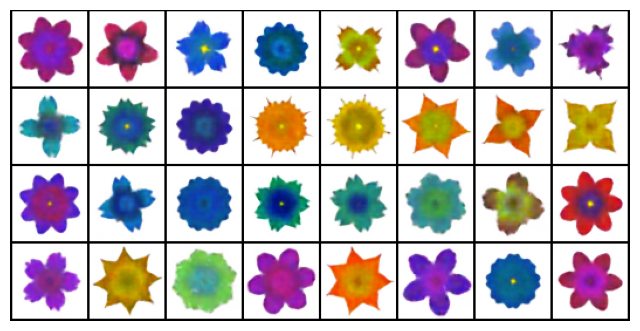

In [11]:
output_image = model.decode(model.encode(real_batch[0]).data).data
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(output_image, padding = 2).cpu(), (1, 2, 0)))

- 2:08 START
- 2:10 2
- 2:15 5
- 2:20 11
- 2:25 15
- 2:30 20
- 2:35 24
- 2:40 28
- 2:45 -
- 2:50 39
- 2:55 43
- 3:00 48
- 3:05 52
- 3:10 57
- 3:15 61
- 3:20 66
- 3:25 72
- 3:30 77
- 3:35 80
- 3:40 -
- 3:45 90
- 3:50 95
- 3:55 100
- 4:00 -
- 4:05 109
- 4:10 -
- 4:15 119
- 4:20 124
- 4:25 -
- 4:30 -
- 4:35 138
- 4:40 -
- 4:45 -
- 4:50 153
- 4:55 -
- 5:00 -
- 5:05 166
- 5:10 -
- 5:15 177
- 5:20 181
- 5:25 185
- 5:30 190
- 5:35 194
- 5:40 END
